# Computational Statistics Project
#### Loan, Fabia and Leila

***

### Understanding and Exploration of Data

In [2]:
# Libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from scipy.stats import ttest_ind # to simplify the t-test
import itertools # so that we won't have to write all the values "by hand" for the 2^k plan
from statsmodels.formula.api import ols # model adjustment, ...
import statsmodels.api as sm # for ANOVA

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [4]:
print(train.shape)

(1460, 81)


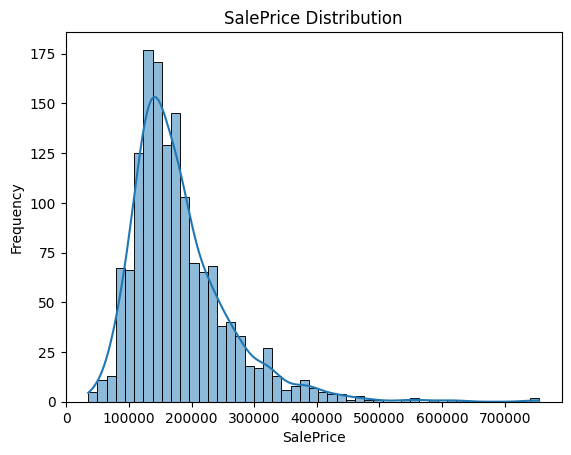

In [5]:
# Visualization of Target Variable (SalePrice)
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

In [6]:
# Basic Statistics of SalePrice
print(train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [7]:
# Confidence Interval for SalePrice mean
sample = train['SalePrice']
n = len(sample)
mean = np.mean(sample)
std = np.std(sample, ddof=1)

conf_int = stats.t.interval(confidence=0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))
print(f"95% Confidence Interval for SalePrice mean: {conf_int}")

95% Confidence Interval for SalePrice mean: (176842.84104108496, 184999.55073973694)


### Handling missing values

In [8]:
# To check if handling missing values will be necessary
print("Missing values in train? --> ", train.isnull().sum().sum())
print("Missing values in test? --> ", test.isnull().sum().sum())

Missing values in train? -->  7829
Missing values in test? -->  7878


In [9]:
# Numerical & Categorical columns (without SalePrice)
num_cols = train.select_dtypes(include=[np.number]).columns.drop('SalePrice')
cat_cols = train.select_dtypes(include=["object"]).columns

# Statistics in the train test (to fill missing values)
num_medians = train[num_cols].median()
cat_modes = train[cat_cols].mode().iloc[0]

# Application for train
train[num_cols] = train[num_cols].fillna(num_medians)
train[cat_cols] = train[cat_cols].fillna(cat_modes)

# Application for test (according to train Statistics)
test[num_cols] = test[num_cols].fillna(num_medians)
test[cat_cols] = test[cat_cols].fillna(cat_modes)

# Verification
print("Missing values in train? --> ", train.isnull().sum().sum())
print("Missing values in test? --> ", test.isnull().sum().sum())

Missing values in train? -->  0
Missing values in test? -->  0


***

### Encoding for categorical variables (One-hot encoding)

In [10]:
# All data together for a coherent encoding
train['is_train'] = 1
test['is_train'] = 0
full_data = pd.concat([train, test], axis=0)

# One-hot encoding on all categorical variables
full_data = pd.get_dummies(full_data, columns=cat_cols, drop_first=True)

# "Re"-separation of the two datasets
train = full_data[full_data['is_train'] == 1].drop(columns='is_train')
test = full_data[full_data['is_train'] == 0].drop(columns=['is_train', 'SalePrice']) # (drop Saleprice because not in test)

***

### Checking Correlation for a more "objective analysis"

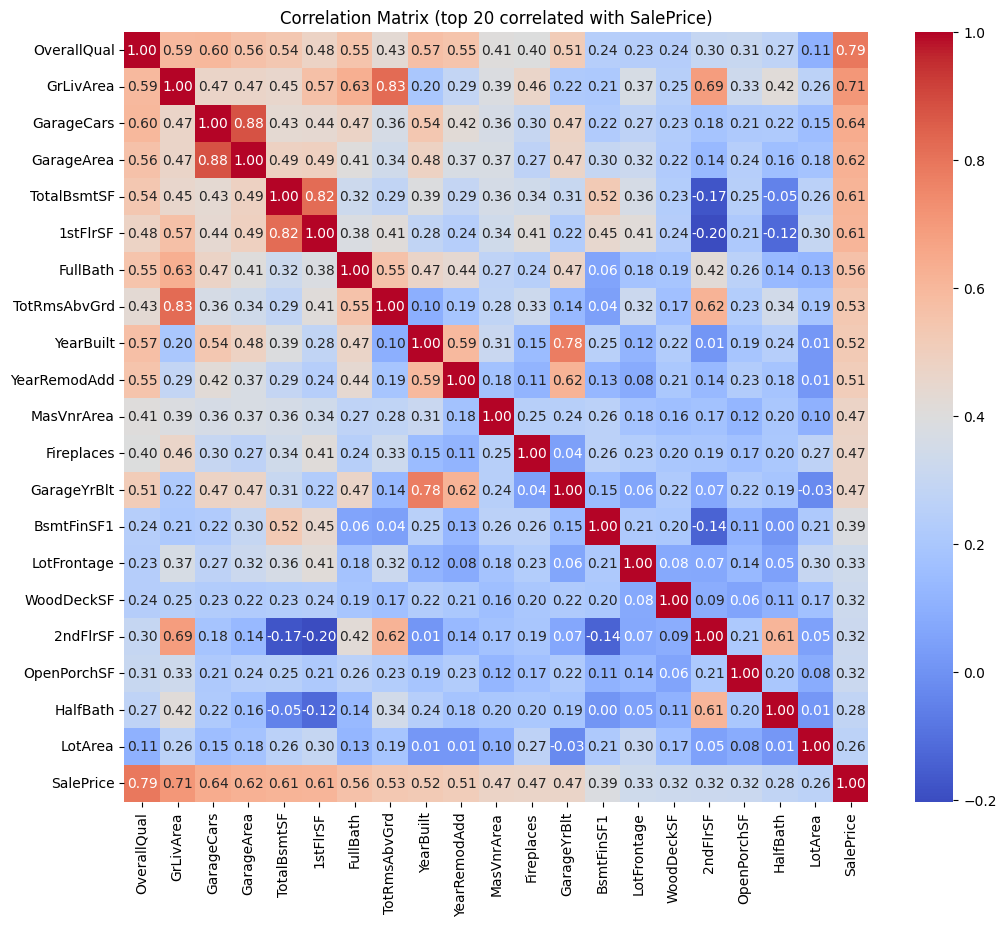

In [11]:
# Numerical columns
numeric_train = train.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = numeric_train.corr()

# Correlation with SalePrice
top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)[1:21] # top 20
top_corr_vars = top_corr.index.to_list()

# Heatmap of top variables correlated with SalePrice
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_train[top_corr.index.to_list() + ['SalePrice']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (top 20 correlated with SalePrice)")
plt.show()

In [12]:
# Detection of pairs that are too correlated (to avoid redundancy)

# Sub-matrix of top-correlated
top_corr_matrix = corr_matrix.loc[top_corr_vars, top_corr_vars].abs()

# "Upper triangle"
upper = top_corr_matrix.where(np.triu(np.ones(top_corr_matrix.shape), k=1).astype(bool))

# Let's assume that a |correlation| > 0.8  is too near to 1
threshold = 0.8

# Pairs highly correlated
high_corr_pairs = [
    (var1, var2, upper.loc[var2, var1])
    for var1 in upper.columns
    for var2 in upper.index
    if upper.loc[var2, var1] > threshold
]

# Results
print("Peers with high correlation in the top 20 (|corr| > 0.8):")
for v1, v2, val in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"{v1} <=> {v2} with correlation = {val:.2f}")

Peers with high correlation in the top 20 (|corr| > 0.8):
GarageArea <=> GarageCars with correlation = 0.88
TotRmsAbvGrd <=> GrLivArea with correlation = 0.83
1stFlrSF <=> TotalBsmtSF with correlation = 0.82


--> For each peer, we select the variable most correlated with price (to avoid multi-colinearity) :
- GarageCars (0.64 > 0.62), GrLivArea (0.71 > 0.53), and TotalBsmtSF (both 0.61 so we chose randomely).

The correlation analysis allows us to proceed with 17 variables. However, it is important not to confuse correlation & causality. We will need to analyze these variables further and build the models accordingly.

***

### Apply RFE to further select the relevant features - (Machine Learning Course)

In [13]:
# X = selected features, y = SalePrice
X = train[top_corr_vars]
y = train['SalePrice']

# Basic Linear Model for the Selection
model = LinearRegression()

# RFE : here, we chose to keep the 10 most "relevant" features
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)

# Results
selected_features = X.columns[rfe.support_]
print("Feature Selection (RFE) :")
print(selected_features.tolist())

Feature Selection (RFE) :
['OverallQual', 'GarageCars', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'GarageYrBlt', 'LotFrontage', 'HalfBath']


***

Since working with 81 features is too extensive for initial modeling, we decided to limit our statistical models to a subset of 10 variables. To select them, we first visualized their correlation with SalePrice and identified the top 20 most correlated features. We then removed highly correlated pairs to avoid redundancy. Finally, we applied Recursive Feature Elimination (RFE from sklearn) to narrow our selection down to 10 features, which will serve as the starting point for our modeling.

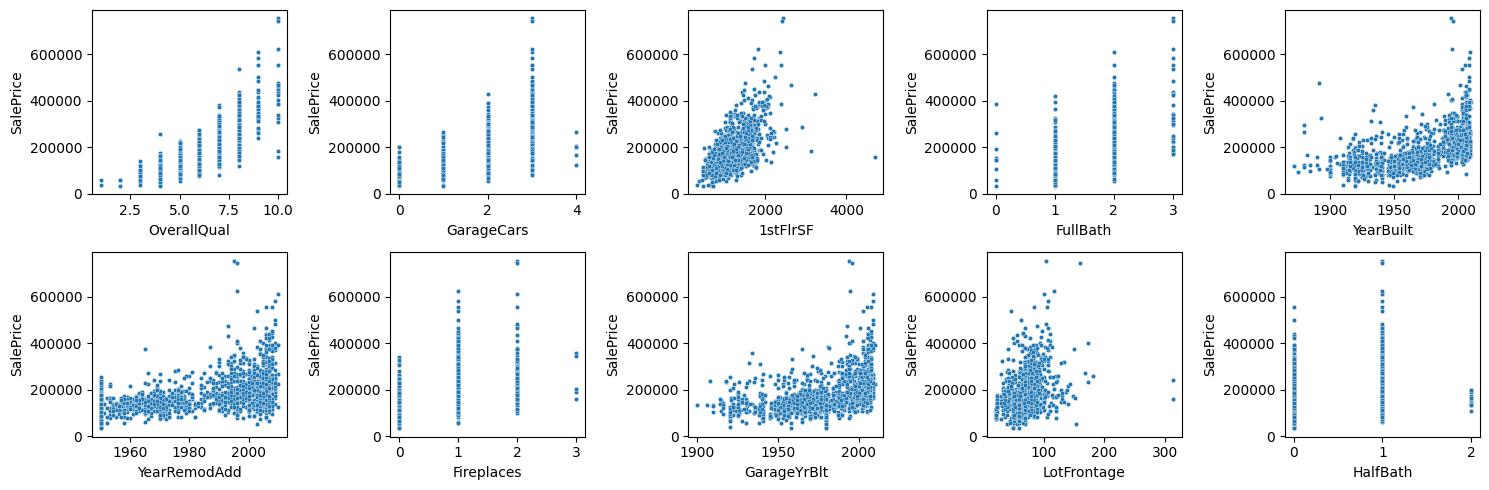

In [14]:
# Scatterplots : SalePrice vs each selected variable
plt.figure(figsize=(15, 5))
for i, col in enumerate(selected_features):
    plt.subplot(2, 5, i + 1)
    sns.scatterplot(x=train[col], y=train['SalePrice'], s=10)
plt.tight_layout()
plt.show()

The Scatterplots enable us to have a visualisation of the relation between each variable and SalePrice. They reveal that several variables, such as OverallQual, 1stFlrSF, and GarageCars, show strong and clear positive relationships with SalePrice, making them promising predictors. Others, like YearBuilt and LotFrontage, display more dispersed patterns...

--> After those first observations, analysis, data cleaning, feature selection, ... We can begin with the core of the project!

***

### Classical statistical inference - Hypothesis Testing

Recap Starting Point :
- OverallQual (Rates the overall material and finish of the house (10-1);
- GarageCars (Size of garage in car capacity);
- 1stFlrSF (First Floor square feet);
- FullBath (Full bathrooms above grade);
- YearBuilt (Original construction date);
- YearRemodAdd (Remodel date (same as construction date if no remodeling or additions));
- Fireplaces (Number of fireplaces);
- GarageYrBlt (Year garage was built);
- LotFrontage (Linear feet of street connected to property);
- HalfBath (Half baths above grade).

Until now, we did some basic statistics and observations of the data, and we selected 10 features that seemed relevant. Based on that, we will now proceed with some Hypothesis Testing, which will help confirm the relevance of the chosen variables.

#### Hypothesis 1 : "Houses with place for more than one car in the garage have a highest SalePrice mean."

In [15]:
# Binary varibale for > 1 car place
train['Garage2plus'] = (train['GarageCars'] > 1).astype(int)

# Our two groups
group1 = train[train['Garage2plus'] == 0]['SalePrice']
group2 = train[train['Garage2plus'] == 1]['SalePrice']

# T-test
t_stat, p_val = ttest_ind(group1, group2, equal_var=False, alternative='less') # alternative='less' to do a unilateral test (SalePrice higher if place for more cars)

print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: -27.912074861943335, p-value: 8.885014618926633e-138


--> Like expected, the variable GarageCars has a relevant impact on SalePrice with a very low p-value. This confirms the pertinence of our previous feature selection.

#### Hypothesis 2 : "Houses with at least one fireplace are more expensive than those without."

In [16]:
train['HasFireplace'] = (train['Fireplaces'] > 0).astype(int)
group1 = train[train['HasFireplace'] == 0]['SalePrice']
group2 = train[train['HasFireplace'] >= 1]['SalePrice']

t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: -21.105376324953664, p-value: 4.666259945494159e-84


--> Here the result also show an impact on the SalePrice.

Hypothesis testing on one feature is too large to create a trustable model. We will therefore proceed with applying the $2^k$, fractional factorial design, and ANOVA. This will enable us to deepen even more the feature selection, taking into account interactions and compute models.

***

### $2^k$ fractional factorial design

Based on the pre-selected variables, we chose 5 relevant factors for the factorial design ($2^5$) :
- OverallQual (high quality when >= to 7);
- GarageCars (big garage if more than 2 places);
- YearBuilt (new house if built after 1999);
- Fireplaces (has Fireplace(s) or not);
- LotFrontage (wide frontage if >= to the median).

In [17]:
# "Binarization" of the factors (to enable the 2^k design)

# 1. High quality (OverallQual >= 7)
train['HighQual'] = np.where(train['OverallQual'] >= 7, 1, -1)

# 2. Big garage (GarageCars >= 2)
train['BigGarage'] = np.where(train['GarageCars'] >= 2, 1, -1)

# 3. New house (YearBuilt >= 2000)
train['NewHouse'] = np.where(train['YearBuilt'] >= 2000, 1, -1)

# 4. Has fireplace (Fireplaces >= 1)
train['HasFireplace'] = np.where(train['Fireplaces'] >= 1, 1, -1)

# 5. Wide frontage (LotFrontage >= médiane)
frontage_median = train['LotFrontage'].median()
train['WideFrontage'] = np.where(train['LotFrontage'] >= frontage_median, 1, -1)

# Dataset extract / verification (binary columns and SalePrice)
binary_factors = ['HighQual', 'BigGarage', 'NewHouse', 'HasFireplace', 'WideFrontage']
display(train[binary_factors + ['SalePrice']].head())

,HighQual,BigGarage,NewHouse,HasFireplace,WideFrontage,SalePrice
0,1,1,1,-1,-1,208500.0
1,-1,1,-1,1,1,181500.0
2,1,1,1,1,-1,223500.0
3,1,1,-1,1,-1,140000.0
4,1,1,1,1,1,250000.0


In [18]:
# To proceed, we need to generate the 2^5 plan (32 combinations)

factors = ['HighQual', 'BigGarage', 'NewHouse', 'HasFireplace', 'WideFrontage']

# Cartesian product of [-1, +1] for each factor
design_matrix = pd.DataFrame(
    list(itertools.product([-1, 1], repeat=len(factors))),
    columns=factors
)
# design_matrix.head()

In [19]:
# Now, let's calculate SalePrice's mean for each combination
# -> We associate each combination of the 2^5 plan with the dataset rows, then calculate the average SalePrice for each combination.

# Empty column for the SalePrice's mean
design_matrix['MeanSalePrice'] = np.nan

# Loop over each combination to filter the corresponding rows and calculate the mean
for i, row in design_matrix.iterrows():
    # condition to filter out lines with exactly the right levels
    condition = (train[factors] == row[factors].values).all(axis=1)
    matching_rows = train[condition]

    if not matching_rows.empty:
        design_matrix.loc[i, 'MeanSalePrice'] = matching_rows['SalePrice'].mean()

# Display of the final design matrix
display(design_matrix)

,HighQual,BigGarage,NewHouse,HasFireplace,WideFrontage,MeanSalePrice
0,-1,-1,-1,-1,-1,107312.033898
1,-1,-1,-1,-1,1,125789.023438
2,-1,-1,-1,1,-1,128213.655738
3,-1,-1,-1,1,1,144682.203390
4,-1,-1,1,-1,-1,NaN
5,-1,-1,1,-1,1,115750.000000
6,-1,-1,1,1,-1,NaN
7,-1,-1,1,1,1,NaN
8,-1,1,-1,-1,-1,125452.917647
9,-1,1,-1,-1,1,144826.463415


***

### ANOVA

--> To continue with ANOVA, we first have to filter the combinations that do not exist (NaN) ...

In [20]:
# Delete lines with MeanSalePrice missing (NaN)
design_matrix_clean = design_matrix.dropna(subset=['MeanSalePrice']).copy()
# design_matrix_clean

In [21]:
# Linear formula (**2 for two-factor interactions)
formula = 'MeanSalePrice ~ (HighQual + BigGarage + NewHouse + HasFireplace + WideFrontage)**2'

# Model adjustment (with ols)
model = ols(formula, data=design_matrix_clean).fit()

# ANOVA type II
anova_table = sm.stats.anova_lm(model, typ=2)

# Results
print(anova_table)

                                 sum_sq   df           F        PR(>F)
HighQual                   2.017942e+10  1.0  180.170850  2.948883e-07
BigGarage                  8.279639e+09  1.0   73.924312  1.238932e-05
NewHouse                   1.145387e+09  1.0   10.226524  1.086798e-02
HasFireplace               7.844563e+09  1.0   70.039755  1.541200e-05
WideFrontage               2.210836e+09  1.0   19.739332  1.616709e-03
HighQual:BigGarage         6.407024e+08  1.0    5.720476  4.044109e-02
HighQual:NewHouse          2.401476e+06  1.0    0.021441  8.868102e-01
HighQual:HasFireplace      1.174110e+09  1.0   10.482976  1.019544e-02
HighQual:WideFrontage      2.213284e+08  1.0    1.976119  1.933700e-01
BigGarage:NewHouse         4.624480e+08  1.0    4.128942  7.270149e-02
BigGarage:HasFireplace     4.624775e+08  1.0    4.129206  7.269387e-02
BigGarage:WideFrontage     9.204146e+07  1.0    0.821787  3.882841e-01
NewHouse:HasFireplace      3.906726e+07  1.0    0.348810  5.693192e-01
NewHou

The ANOVA results from this $2^5$ factorial design reveal several significant effects on house prices. The 5 effects selected (HighQual, BigGarage, NewHouse, HasFireplace, and WideFrontage) all show statistically significant effects. Additionally, the interactions HighQual:BigGarage and HighQual:HasFireplace are statistically significant.

***

From the results of our factorial design $2^5$ and the ANOVA, we can conclude a regression model based on :

*MeanSalePrice = β0 + β1HighQual + β2BigGarage + β3NewHouse + β4HasFireplace + β5WideFrontage + β6(HighQualxBigGarage) + β7(HighQualxHasFireplace) + Error term*

--> We can now fit the regression model based on the 5 factors and the 2 significant interactions, from design_matrix_clean.

In [22]:
# Our model / formula
formula_1 = (
    'MeanSalePrice ~ HighQual + BigGarage + NewHouse + HasFireplace + WideFrontage'
    ' + HighQual:BigGarage + HighQual:HasFireplace'
)

# Model adjustment (with ols)
model_1 = ols(formula_1, data=design_matrix_clean).fit()

# Results summary
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:          MeanSalePrice   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     55.14
Date:                Sun, 25 May 2025   Prob (F-statistic):           1.88e-10
Time:                        22:18:41   Log-Likelihood:                -264.60
No. Observations:                  25   AIC:                             545.2
Df Residuals:                      17   BIC:                             555.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.725e+

This linear regression model explains approximately 96% of the variance in average house prices. All the main effects and interactions are statistically significant (p < 0.05), confirming their influence on the average house prices.

***

### Model Application with the Original Variables

Binarizing the variables allowed us to estimate simple marginal effects. However, the $2^k$ design gave an experimental factorial view, but lost the “richness” of variation in the data. This model is based on aggregations (by group) and is therefore less accurate for individual predictions.

To address this limitation and in order to obtain an individualized prediction, we will now run an OLS regression on the same five predictors, but in their original / continuous form (rather than as binary indicators).

In [23]:
train['LogSalePrice'] = np.log(train['SalePrice']) # to stabilize variance, avoid skewness, ...

# Our model / formula
formula_2 = (
    'LogSalePrice ~ OverallQual + GarageCars + YearBuilt + Fireplaces + LotFrontage'
    ' + OverallQual:GarageCars + OverallQual:Fireplaces'
)

# Model adjustment (with ols)
model_2 = ols(formula_2, data=train).fit()

# Results summary
print(model_2.summary())

# Variance analysis (ANOVA type II)
anova_table_2 = sm.stats.anova_lm(model_2, typ=2)
print(anova_table_2)

                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     698.2
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        22:18:43   Log-Likelihood:                 344.52
No. Observations:                1460   AIC:                            -673.0
Df Residuals:                    1452   BIC:                            -630.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

The OLS model on the original variables explains about 77.1% of the variance in log sale prices. GarageCars alone and the interaction OverallQual:Fireplaces aren't so significant...

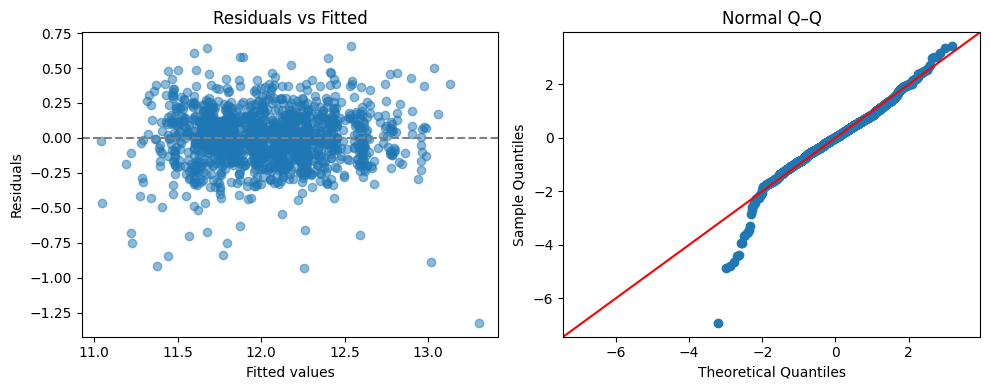

In [24]:
# + to verify homoscedasticity and normality :

fitted = model_2.fittedvalues
resid   = model_2.resid

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.5)
axes[0].axhline(0, color='grey', ls='--')
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

# QQ-plot of residuals
sm.qqplot(resid, line='45', fit=True, ax=axes[1])
axes[1].set_title("Normal Q–Q")

plt.tight_layout()
plt.show()

--> The model’s homoscedasticity and normality assumptions are pretty met : No obvious pattern in the residuals vs fitted plot and the QQ-plot indicates that most residuals follow a normal distribution (aside from a few outliers...).

***

### Let’s Try Another Model

The factorial design model allowed us to analyze the main effects and interactions of five binary features on average house prices. This approach provided interpretable insights and statistically significant results through ANOVA.

Now, we will try to compute another linear regression model (OLS). The goal is to build a new model of SalePrice using key features identified through previous exploratory and analysis.

To do so, we will drop GarageCars, which showed the highest p-value in the last regression, and LotFrontage whose scatterplot relationship was a bit less convincing than the others. To "replace" them, two additional variables are included :
- 1stFlrSF, because of its strong positive correlation with SalePrice --> here we will try to add a small polynomial term (e.g. firstFloorSF$^2$) because his scatterplot with SalePrice showed a "fast accelaration" for larger homes (can give flexibility to the model to capture that curvature).
- TotalBaths, a synthetic variable which will combine full and half baths to reflect overall bathroom capacity.

These choices are backed by our previous exploratory data analysis.

In [25]:
# TotalBaths
train['TotalBaths'] = train['FullBath'] + 0.5 * train['HalfBath']
train['firstFlrSF'] = train['1stFlrSF'] # otherwise didn't work in the model...

# Our model / formula
formula_3 = (
    'LogSalePrice ~ OverallQual + firstFlrSF + YearBuilt + Fireplaces + I(firstFlrSF**2) + TotalBaths'
    ' + OverallQual:GarageCars' # We kept the highly significant interaction
)

# Model adjustment
model_3 = ols(formula_3, data=train).fit()

# Results summary
print(model_3.summary())

# Variance analysis (ANOVA type II)
anova_table_3 = sm.stats.anova_lm(model_3, typ=2)
print(anova_table_3)

                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     932.5
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        22:18:44   Log-Likelihood:                 512.50
No. Observations:                1460   AIC:                            -1009.
Df Residuals:                    1452   BIC:                            -966.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8

This OLS model explains approximately 81.8% of the logarithmized sale‐price variance. All variables and the interaction show strong positive effects (p < 0.001).

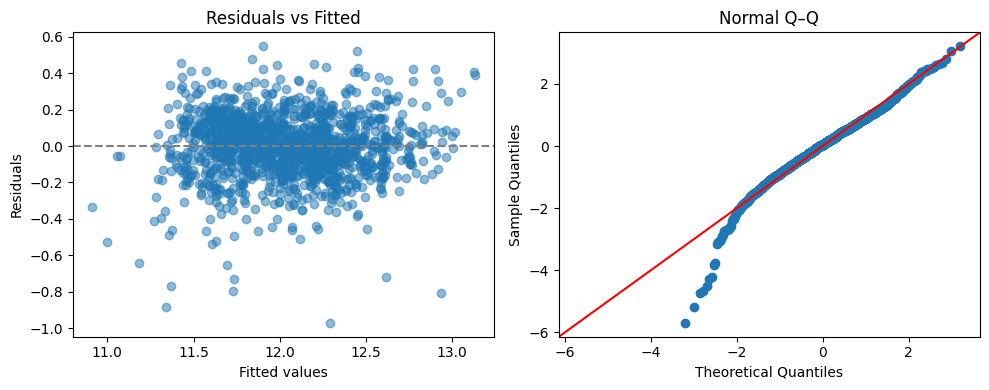

In [26]:
# + to verify homoscedasticity and normality :

fitted = model_3.fittedvalues
resid   = model_3.resid

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.5)
axes[0].axhline(0, color='grey', ls='--')
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")

# QQ-plot of residuals
sm.qqplot(resid, line='45', fit=True, ax=axes[1])
axes[1].set_title("Normal Q–Q")

plt.tight_layout()
plt.show()

--> The model’s homoscedasticity and normality assumptions are pretty met again.

***

### "Testing Phase" : Applying Model 2 and Model 3
Next, we will use two OLS models to generate CSV prediction files for the test set. This will allow us to test their performance more concretely.

In [27]:
# Necessary modifications on test
test['TotalBaths'] = test['FullBath'] + 0.5 * test['HalfBath']
test['firstFlrSF'] = test['1stFlrSF']

# Generation of predictions
test['SalePrice_2'] = np.exp(model_2.predict(test))
test['SalePrice_3'] = np.exp(model_3.predict(test)) # exp because otherwise LogSalePrice predicted

# Save as csv files
csv2 = test[['Id', 'SalePrice_2']].rename(columns={'SalePrice_2':'SalePrice'})
csv2.to_csv('test_model_2.csv', index=False)

csv3 = test[['Id', 'SalePrice_3']].rename(columns={'SalePrice_3':'SalePrice'})
csv3.to_csv('test_model_3.csv', index=False)

print("test_model_2.csv and test_model_3.csv created")

test_model_2.csv and test_model_3.csv created


In [28]:
print(csv2['SalePrice'].describe())

count      1459.000000
mean     177156.542874
std       69912.067431
min       71812.664935
25%      125170.380656
50%      161311.410206
75%      209406.899567
max      512661.158034
Name: SalePrice, dtype: float64


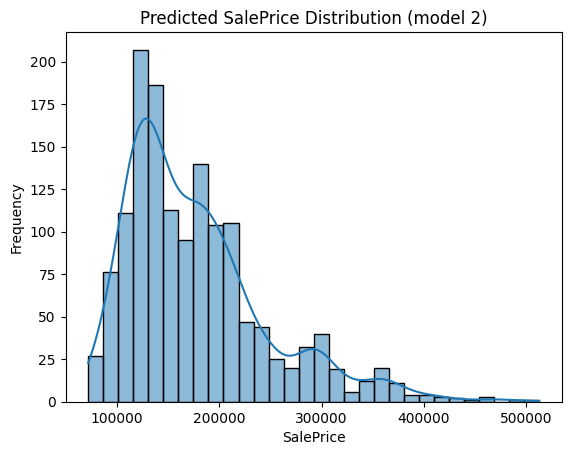

In [29]:
# Visualization of predicted SalePrice
sns.histplot(csv2['SalePrice'], kde=True)
plt.title("Predicted SalePrice Distribution (model 2)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

In [30]:
print(csv3['SalePrice'].describe())

count      1459.000000
mean     177961.925562
std       71241.211453
min       64274.115900
25%      123056.861180
50%      160683.474106
75%      213454.144068
max      480418.703153
Name: SalePrice, dtype: float64


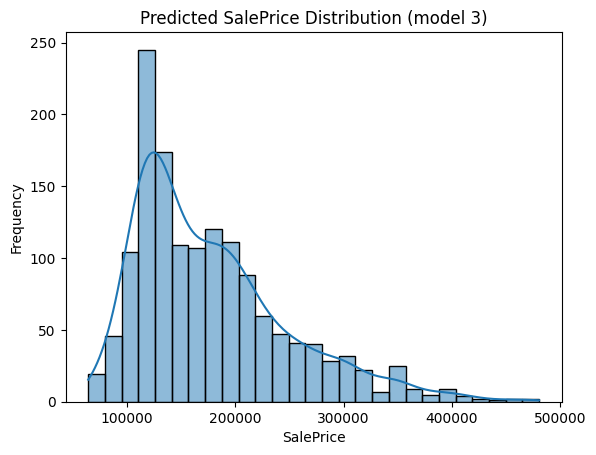

In [31]:
# Visualization of predicted SalePrice
sns.histplot(csv3['SalePrice'], kde=True)
plt.title("Predicted SalePrice Distribution (model 3)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

--> The SalePrice average of the two results lies within the confidence interval generated during data exploration [176842.84 ; 184999.55].

***

### Time Series Analysis, SARIMA models

#### Préparations à la time serie

In [32]:
# Charger les données
train_path = "train.csv"
train_df = pd.read_csv(train_path)

# Afficher les premières lignes pour identifier les colonnes pertinentes
train_df[['YrSold', 'MoSold', 'SalePrice']].head()


,YrSold,MoSold,SalePrice
0,2008,2,208500
1,2007,5,181500
2,2008,9,223500
3,2006,2,140000
4,2008,12,250000


In [33]:
# Créer une colonne de date à partir de YrSold et MoSold (en fixant le jour au 1er du mois)
train_df['Date'] = pd.to_datetime(dict(year=train_df.YrSold, month=train_df.MoSold, day=1))

# Grouper par mois et calculer la moyenne des prix de vente
monthly_prices = train_df.groupby('Date')['SalePrice'].mean().sort_index()

# Afficher les premières lignes de la série temporelle
monthly_prices.head()


Date
2006-01-01    201090.000000
2006-02-01    194322.222222
2006-03-01    184982.200000
2006-04-01    174312.814815
2006-05-01    158928.289474
Name: SalePrice, dtype: float64

#### Creation of the first time series model

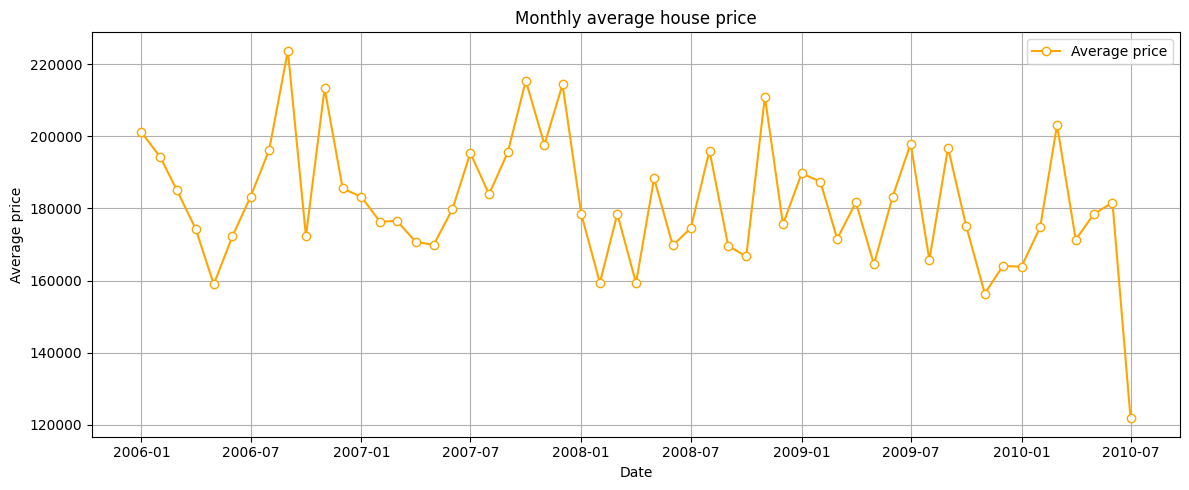

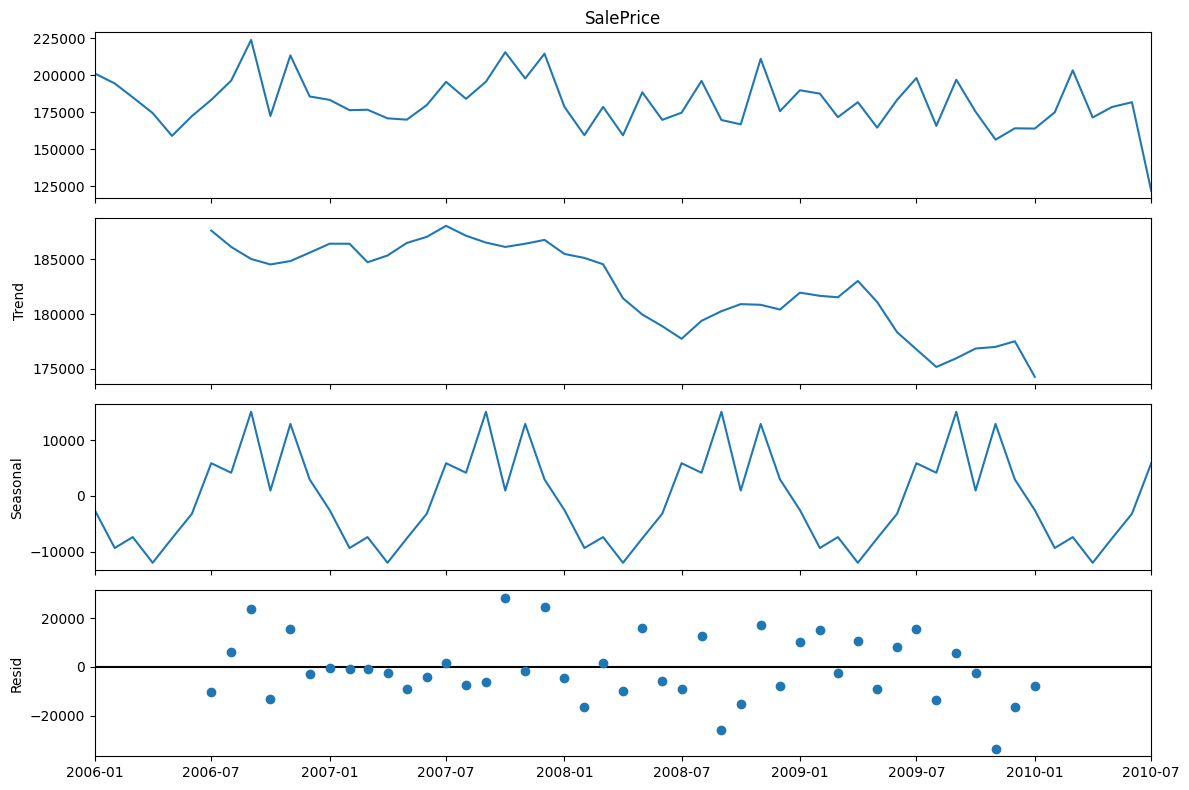

{'ADF Statistic': -4.346575115335641,
 'p-value': 0.0003685708474917368,
 'Used Lag': 3,
 'Number of Observations Used': 51,
 'Critical Values': {'1%': -3.5656240522121956,
  '5%': -2.920142229157715,
  '10%': -2.598014675124952}}

In [35]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Visualisation de la série temporelle
plt.figure(figsize=(12, 5))
plt.plot(monthly_prices, marker='o', linestyle='-', label='Average price', color="orange", markerfacecolor = "white")
plt.title("Monthly average house price")
plt.xlabel("Date")
plt.ylabel("Average price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Test de stationnarité (Augmented Dickey-Fuller)
adf_result = adfuller(monthly_prices.dropna())
adf_output = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Used Lag': adf_result[2],
    'Number of Observations Used': adf_result[3],
    'Critical Values': adf_result[4]
}

# 3. Décomposition de la série (additive)
decomposition = seasonal_decompose(monthly_prices, model='additive', period=12)

# Tracer la décomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

adf_output


#### Pfirst SARIMA model

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définir une configuration de base pour SARIMA (p,d,q)(P,D,Q,s)
# Choix arbitraire initial : (1,1,1)x(1,1,1,12)
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Ajuster le modèle
sarima_model = SARIMAX(monthly_prices, 
                       order=sarima_order, 
                       seasonal_order=seasonal_order, 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

# Résumé du modèle
sarima_result.summary()


/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          SalePrice   No. Observations:                   55
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -568.720
Date:                            Sun, 25 May 2025   AIC                           1147.441
Time:                                    22:18:49   BIC                           1154.102
Sample:                                01-01-2006   HQIC                          1149.477
                                     - 07-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4650         -0        inf      0.000      -0.465      -0.465
ma.L1         -0.3010         -0        inf      0.000      -0.301      -0.301
ar.S.L12      -1.5205   4.22e-27   -3.6e+26      0.000      -1.521      -1.521
ma.S.L12   -2.367e+14   2.88e-33  -8.23e+46      0.000   -2.37e+14   -2.37e+14
sigma2      1.246e-12   3.59e-10      0.003      0.997   -7.02e-10    7.04e-10
===================================================================================
Ljung-Box (L1) (Q):                   1.24   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.27   Prob(JB):                         0.75
Heteroskedasticity (H):               1.35   Skew:                             0.15
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

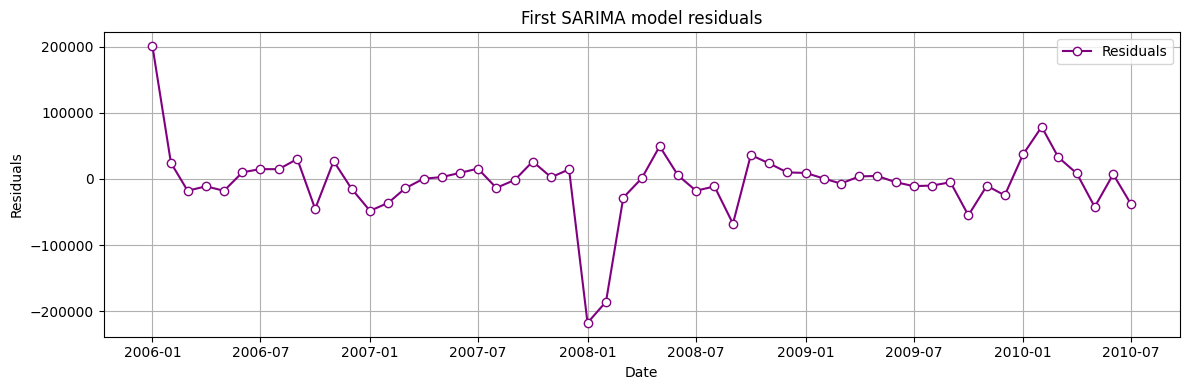

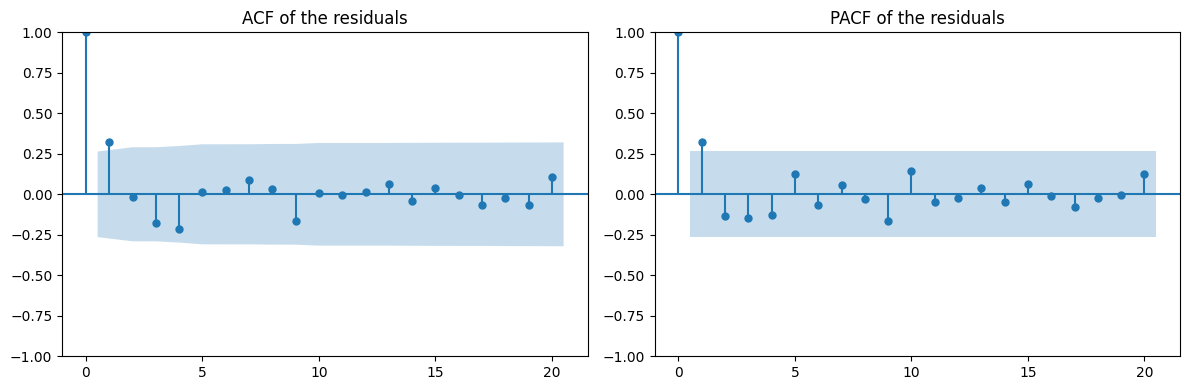

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extraire les résidus
residuals = sarima_result.resid

# Tracer les résidus
plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals', marker='o', linestyle='-', color='purple', markerfacecolor='white')
plt.title("First SARIMA model residuals")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Tracer ACF et PACF des résidus
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(residuals.dropna(), lags=20, ax=plt.gca())
plt.title("ACF of the residuals")

plt.subplot(1, 2, 2)
plot_pacf(residuals.dropna(), lags=20, ax=plt.gca())
plt.title("PACF of the residuals")

plt.tight_layout()
plt.show()


#### Tests of oder SARIMA configurations

In [38]:
# Tester une configuration plus simple : SARIMA(1,1,1)(0,1,1,12)
alt_order = (1, 0, 1)
alt_seasonal_order = (1, 1, 1, 12)

# Ajuster le modèle
alt_model = SARIMAX(monthly_prices, 
                    order=alt_order, 
                    seasonal_order=alt_seasonal_order, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
alt_result = alt_model.fit(disp=False)

# Résumé du modèle
alt_result.summary()


/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          SalePrice   No. Observations:                   55
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -477.670
Date:                            Sun, 25 May 2025   AIC                            965.341
Time:                                    22:18:51   BIC                            972.177
Sample:                                01-01-2006   HQIC                           967.482
                                     - 07-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2382   5.16e-24  -4.62e+22      0.000      -0.238      -0.238
ma.L1         -0.0114   6.02e-24   -1.9e+21      0.000      -0.011      -0.011
ar.S.L12      -0.9693   3.04e-24  -3.19e+23      0.000      -0.969      -0.969
ma.S.L12   -1.625e+14   4.11e-33  -3.95e+46      0.000   -1.63e+14   -1.63e+14
sigma2      1.222e-15   3.52e-10   3.47e-06      1.000   -6.91e-10    6.91e-10
===================================================================================
Ljung-Box (L1) (Q):                   4.81   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.03   Prob(JB):                         0.29
Heteroskedasticity (H):               2.66   Skew:                            -0.70
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.98e+61. Standard errors may be unstable.
"""

In [44]:
# Troisième configuration testée : SARIMA(0,1,1)(0,1,1,12)
third_order = (0, 1, 1)
third_seasonal_order = (1, 1, 1, 12)

# Ajuster le modèle
third_model = SARIMAX(monthly_prices, 
                      order=third_order, 
                      seasonal_order=third_seasonal_order, 
                      enforce_stationarity=False, 
                      enforce_invertibility=False)
third_result = third_model.fit(disp=False)

# Résumé du modèle
third_result.summary()


/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          SalePrice   No. Observations:                   55
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -659.598
Date:                            Sun, 25 May 2025   AIC                           1327.196
Time:                                    22:19:36   BIC                           1332.525
Sample:                                01-01-2006   HQIC                          1328.825
                                     - 07-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7669         -0        inf      0.000      -0.767      -0.767
ar.S.L12      -1.5205         -0        inf      0.000      -1.521      -1.521
ma.S.L12   -2.367e+14   6.23e-33   -3.8e+46      0.000   -2.37e+14   -2.37e+14
sigma2      8.218e-10   5.28e-10      1.557      0.120   -2.13e-10    1.86e-09
===================================================================================
Ljung-Box (L1) (Q):                   1.41   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.24   Prob(JB):                         0.70
Heteroskedasticity (H):               0.56   Skew:                            -0.39
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [45]:
# Troisième configuration testée : SARIMA(0,1,1)(0,1,1,12)
third_order = (1, 1, 0)
third_seasonal_order = (1, 1, 1, 12)

# Ajuster le modèle
third_model = SARIMAX(monthly_prices, 
                      order=third_order, 
                      seasonal_order=third_seasonal_order, 
                      enforce_stationarity=False, 
                      enforce_invertibility=False)
third_result = third_model.fit(disp=False)

# Résumé du modèle
third_result.summary()


/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            SalePrice   No. Observations:                   55
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -656.644
Date:                              Sun, 25 May 2025   AIC                           1321.287
Time:                                      22:19:37   BIC                           1326.756
Sample:                                  01-01-2006   HQIC                          1323.000
                                       - 07-01-2010                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5936        nan        nan        nan         nan         nan
ar.S.L12      -1.5205         -0        inf      0.000      -1.521      -1.521
ma.S.L12   -2.367e+14   3.17e-33  -7.47e+46      0.000   -2.37e+14   -2.37e+14
sigma2       1.32e-10   3.73e-10      0.354      0.724      -6e-10    8.64e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.64   Prob(JB):                         0.82
Heteroskedasticity (H):               1.29   Skew:                             0.13
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

##### Les deux sont moins bonne même quand elles sont plus stables 

#### Second time series with a centered moving average of 3 months

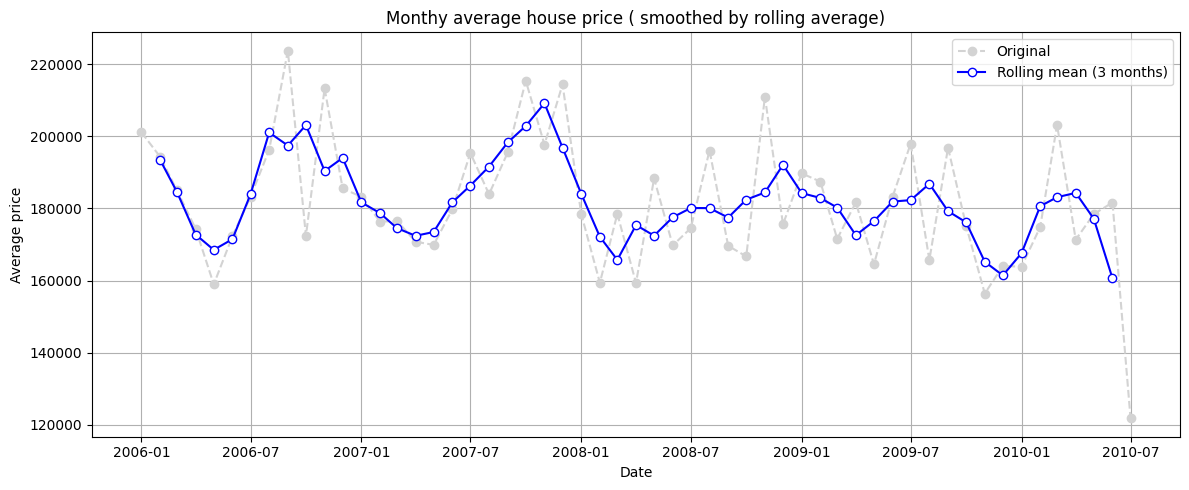

/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          SalePrice   No. Observations:                   53
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -541.589
Date:                            Sun, 25 May 2025   AIC                           1093.177
Time:                                    22:18:53   BIC                           1099.467
Sample:                                02-01-2006   HQIC                          1094.988
                                     - 06-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5353         -0       -inf      0.000       0.535       0.535
ma.L1         -0.4910         -0        inf      0.000      -0.491      -0.491
ar.S.L12      -2.0656   5.25e-28  -3.94e+27      0.000      -2.066      -2.066
ma.S.L12   -7.284e+14   9.69e-34  -7.51e+47      0.000   -7.28e+14   -7.28e+14
sigma2      3.716e-13   3.72e-10      0.001      0.999   -7.29e-10     7.3e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.66   Prob(JB):                         0.64
Heteroskedasticity (H):               1.55   Skew:                             0.38
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [40]:
# Appliquer un lissage avec une moyenne mobile (rolling mean) sur la série des prix mensuels
# Utilisons une fenêtre de 3 mois pour capter les tendances locales sans trop lisser
smoothed_prices = monthly_prices.rolling(window=3, center=True).mean()

# Afficher la série lissée
plt.figure(figsize=(12, 5))
plt.plot(monthly_prices, label='Original', color='lightgray', linestyle='--', marker='o')
plt.plot(smoothed_prices, label='Rolling mean (3 months)', color='blue', marker='o', markerfacecolor='white')
plt.title("Monthy average house price ( smoothed by rolling average)")
plt.xlabel("Date")
plt.ylabel("Average price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Supprimer les valeurs manquantes générées par le rolling
smoothed_prices_clean = smoothed_prices.dropna()

# Ajuster un modèle SARIMA sur la série lissée
# On repart sur le même modèle de base : (1,1,1)(1,1,1,12)
sarima2_model = SARIMAX(smoothed_prices_clean,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima2_result = sarima2_model.fit(disp=False)

# Résumé du modèle
sarima2_result.summary()


#### Tests of oder configurations for the second model

In [46]:
sarima2_model = SARIMAX(smoothed_prices_clean,
                        order=(0, 1, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima2_result = sarima2_model.fit(disp=False)

# Résumé du modèle
sarima2_result.summary()

/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          SalePrice   No. Observations:                   53
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -548.177
Date:                            Sun, 25 May 2025   AIC                           1104.354
Time:                                    22:23:30   BIC                           1109.386
Sample:                                02-01-2006   HQIC                          1105.803
                                     - 06-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0418         -0       -inf      0.000       0.042       0.042
ar.S.L12      -2.0656         -0        inf      0.000      -2.066      -2.066
ma.S.L12   -7.284e+14    9.7e-34  -7.51e+47      0.000   -7.28e+14   -7.28e+14
sigma2      6.168e-13   3.72e-10      0.002      0.999   -7.29e-10     7.3e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.71   Prob(JB):                         0.62
Heteroskedasticity (H):               1.57   Skew:                             0.40
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [47]:
sarima2_model = SARIMAX(smoothed_prices_clean,
                        order=(1, 0, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima2_result = sarima2_model.fit(disp=False)

# Résumé du modèle
sarima2_result.summary()

/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          SalePrice   No. Observations:                   53
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -279.441
Date:                            Sun, 25 May 2025   AIC                            568.883
Time:                                    22:23:30   BIC                            575.362
Sample:                                02-01-2006   HQIC                           570.809
                                     - 06-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6322      0.309      2.045      0.041       0.026       1.238
ma.L1          0.4798      0.301      1.596      0.111      -0.110       1.069
ar.S.L12      -0.3071      0.297     -1.033      0.302      -0.890       0.276
ma.S.L12      -0.1115      0.199     -0.559      0.576      -0.502       0.279
sigma2      8.419e+07   1.14e-09   7.37e+16      0.000    8.42e+07    8.42e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.39   Prob(JB):                         0.65
Heteroskedasticity (H):               4.15   Skew:                            -0.44
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.35e+32. Standard errors may be unstable.
"""

In [48]:
sarima2_model = SARIMAX(smoothed_prices_clean,
                        order=(1, 1, 0),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima2_result = sarima2_model.fit(disp=False)

# Résumé du modèle
sarima2_result.summary()

/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            SalePrice   No. Observations:                   53
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -656.370
Date:                              Sun, 25 May 2025   AIC                           1320.739
Time:                                      22:23:31   BIC                           1325.923
Sample:                                  02-01-2006   HQIC                          1322.281
                                       - 06-01-2010                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0705         -0       -inf      0.000       0.070       0.070
ar.S.L12      -2.0656         -0        inf      0.000      -2.066      -2.066
ma.S.L12   -7.284e+14   1.36e-33  -5.36e+47      0.000   -7.28e+14   -7.28e+14
sigma2      3.912e-10   4.36e-10      0.896      0.370   -4.64e-10    1.25e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.78   Prob(JB):                         0.58
Heteroskedasticity (H):               1.16   Skew:                             0.34
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

#### Comparison of both SARIMA models

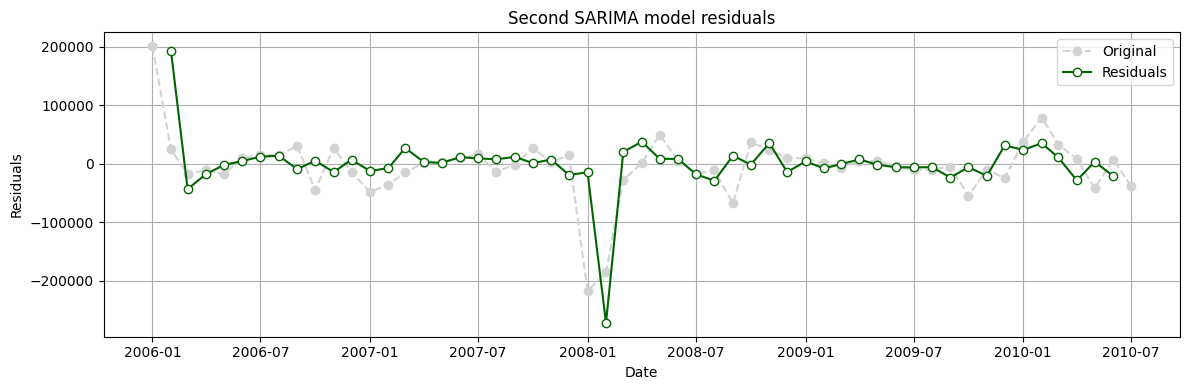

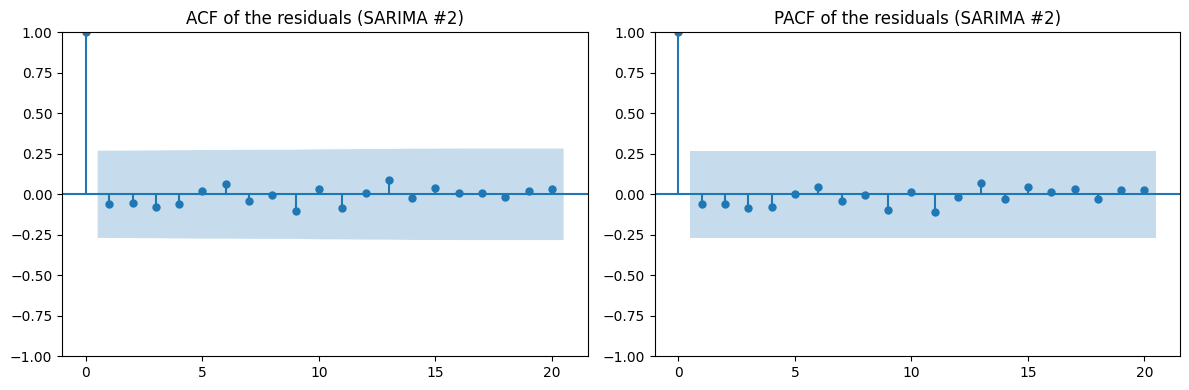

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Résidus du modèle SARIMA 2
resid2 = sarima2_result.resid

# Tracer les résidus
plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Original', color='lightgray', linestyle='--', marker='o')
plt.plot(resid2, label='Residuals', marker='o', linestyle='-', color='darkgreen', markerfacecolor='white')
plt.title("Second SARIMA model residuals")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2. ACF et PACF des résidus
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(resid2.dropna(), lags=20, ax=plt.gca())
plt.title("ACF of the residuals (SARIMA #2)")

plt.subplot(1, 2, 2)
plot_pacf(resid2.dropna(), lags=20, ax=plt.gca())
plt.title("PACF of the residuals (SARIMA #2)")

plt.tight_layout()
plt.show()


/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/jlab-env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


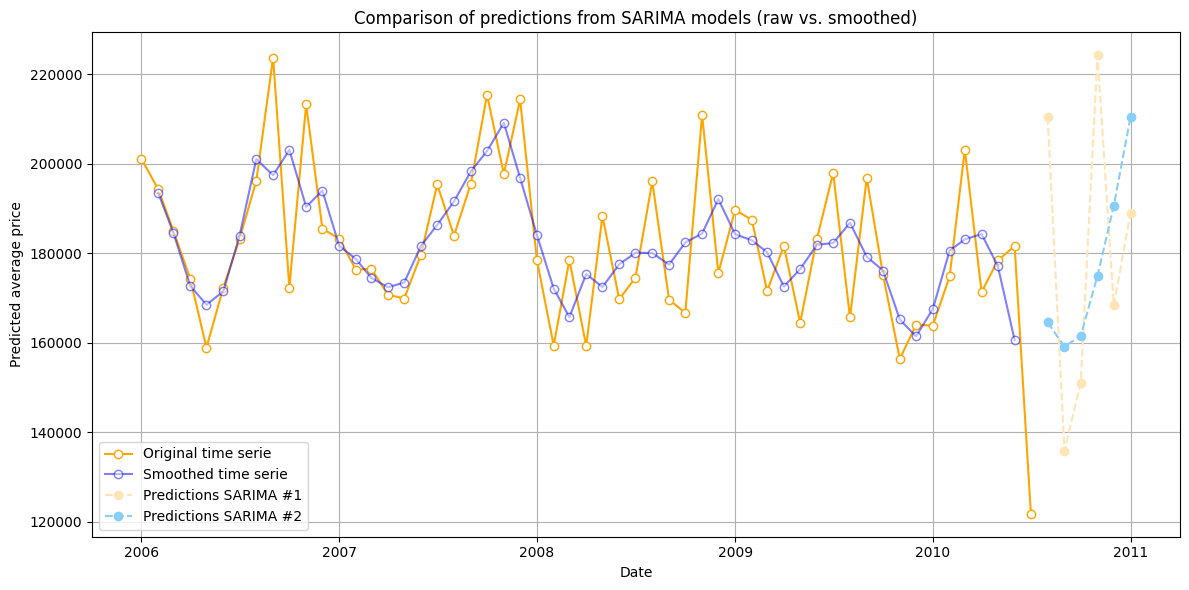

In [42]:
# Générer les prévisions sur 6 mois avec les deux modèles

# 1. Modèle 1 : SARIMA sur la série brute
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Recharge les données de base
train_df = pd.read_csv("train.csv")
train_df['Date'] = pd.to_datetime(dict(year=train_df.YrSold, month=train_df.MoSold, day=1))
monthly_prices = train_df.groupby('Date')['SalePrice'].mean().sort_index()

# Remettre le modèle 1
sarima1_model = SARIMAX(monthly_prices,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima1_result = sarima1_model.fit(disp=False)

# Forecast sur 6 mois
forecast_horizon = 6
forecast1 = sarima1_result.get_forecast(steps=forecast_horizon)
forecast2 = sarima2_result.get_forecast(steps=forecast_horizon)

# Index temporel pour les prévisions
future_dates = pd.date_range(start=monthly_prices.index[-1] + pd.DateOffset(months=1),
                             periods=forecast_horizon, freq='MS')

# Tracer les prévisions des deux modèles
plt.figure(figsize=(12, 6))
plt.plot(monthly_prices, label="Original time serie", color='orange',marker = "o",markerfacecolor = "white")
plt.plot(smoothed_prices, label="Smoothed time serie", color='blue', alpha=0.5,marker = "o",markerfacecolor = "white")

plt.plot(future_dates, forecast1.predicted_mean, label="Predictions SARIMA #1", color='moccasin',linestyle = "--", marker='o')
plt.plot(future_dates, forecast2.predicted_mean, label="Predictions SARIMA #2", color='lightskyblue',linestyle = "--" , marker='o')

plt.title("Comparison of predictions from SARIMA models (raw vs. smoothed)")
plt.xlabel("Date")
plt.ylabel("Predicted average price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
